# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2023-05-29 13:02:08.887383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 13:02:12.132599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-29 13:02:16.288009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 13:02:16.535377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

# Basic RNNs (Recursive Neural Network)

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


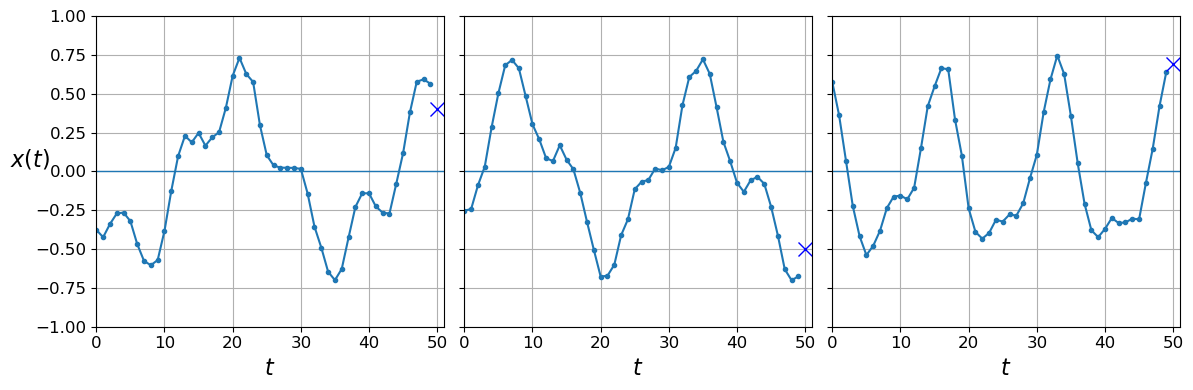

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(
        X_valid[col, :, 0],
        y_valid[col, 0],
        y_label=("$x(t)$" if col == 0 else None),
    )
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2023-05-29 13:02:19.986541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 13:02:19.986961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 13:02:19.987264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

0.020211367

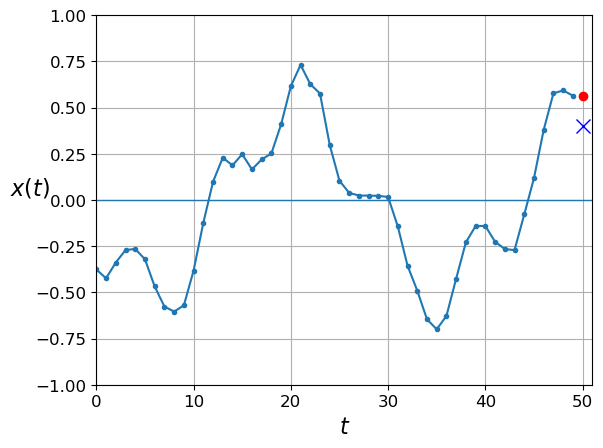

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20


2023-05-29 13:02:22.682458: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f169fb7b9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-29 13:02:22.682493: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti with Max-Q Design, Compute Capability 6.1
2023-05-29 13:02:22.721489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-29 13:02:22.978399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


35/55 [==================>...........] - ETA: 0s - loss: 0.0485  

2023-05-29 13:02:23.309028: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 [==============================] - 2s 4ms/step - loss: 0.0363 - val_loss: 0.0124
Epoch 2/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 3/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 4/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 5/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 7/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 8/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 9/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 10/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 11/20
55/55 [===========

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0033


0.0032704053446650505

In [10]:
model.layers[1].get_weights()

[array([[ 3.45898010e-02],
        [ 4.42233228e-04],
        [ 2.87498999e-02],
        [-3.42315272e-03],
        [-1.48744024e-02],
        [-2.49462225e-03],
        [ 1.10454941e-02],
        [ 6.55020997e-02],
        [ 2.23347498e-03],
        [ 4.54804376e-02],
        [-2.75093950e-02],
        [-6.78274110e-02],
        [ 1.37775438e-02],
        [ 5.87530783e-04],
        [ 6.00425005e-02],
        [-4.86041754e-02],
        [ 5.99241704e-02],
        [ 2.21508997e-03],
        [-1.28063023e-01],
        [-9.10514295e-02],
        [ 4.59470600e-02],
        [ 3.50947194e-02],
        [ 3.65780084e-03],
        [-5.42737916e-02],
        [-1.34546608e-01],
        [-5.22671454e-02],
        [-5.35619408e-02],
        [-5.99225573e-02],
        [-1.14983015e-01],
        [ 5.61527759e-02],
        [-3.49626914e-02],
        [-9.11132991e-02],
        [-1.36947915e-01],
        [-1.88557237e-01],
        [-3.14617343e-02],
        [-1.31075859e-01],
        [ 9.39626098e-02],
 

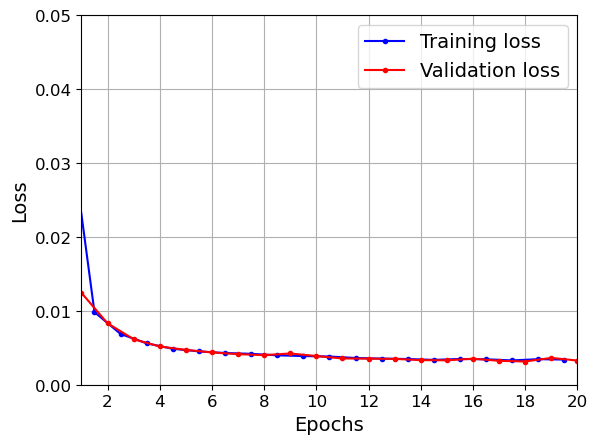

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(
        np.arange(len(val_loss)) + 1,
        val_loss,
        "r.-",
        label="Validation loss",
    )
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


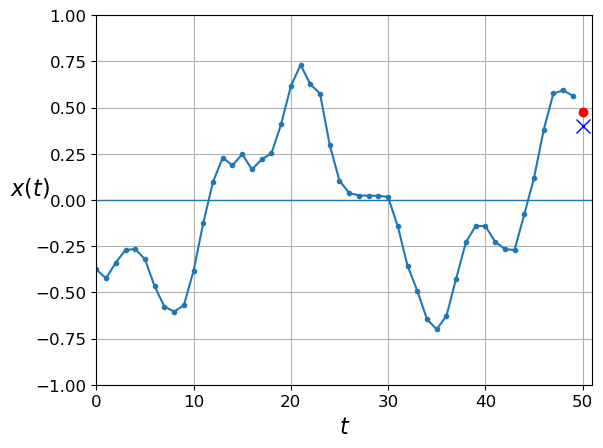

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[50, 1]),
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
55/55 [==============================] - 2s 26ms/step - loss: 0.3340 - val_loss: 0.0769
Epoch 2/20
55/55 [==============================] - 1s 23ms/step - loss: 0.0426 - val_loss: 0.0301
Epoch 3/20
55/55 [==============================] - 1s 23ms/step - loss: 0.0252 - val_loss: 0.0218
Epoch 4/20
55/55 [==============================] - 1s 24ms/step - loss: 0.0197 - val_loss: 0.0178
Epoch 5/20
55/55 [==============================] - 1s 24ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 6/20
55/55 [==============================] - 1s 25ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 7/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 8/20
55/55 [==============================] - 1s 24ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 9/20
55/55 [==============================] - 1s 24ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 10/20
55/55 [==============================] - 1s 24ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 11/

In [16]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0109


0.010875486768782139

In [17]:
model.layers[0].get_weights()

[array([[1.6649331]], dtype=float32),
 array([[-0.67629343]], dtype=float32),
 array([0.00217577], dtype=float32)]

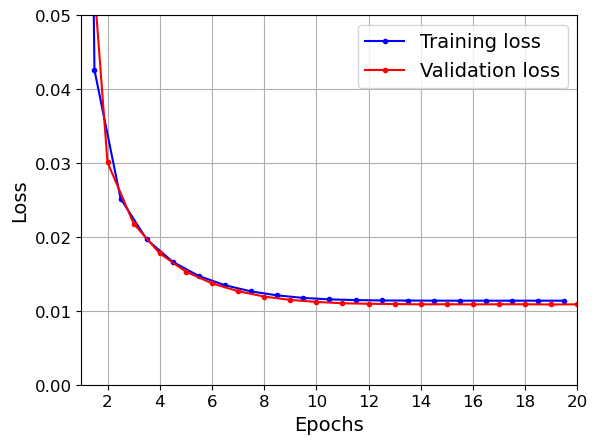

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 6ms/step


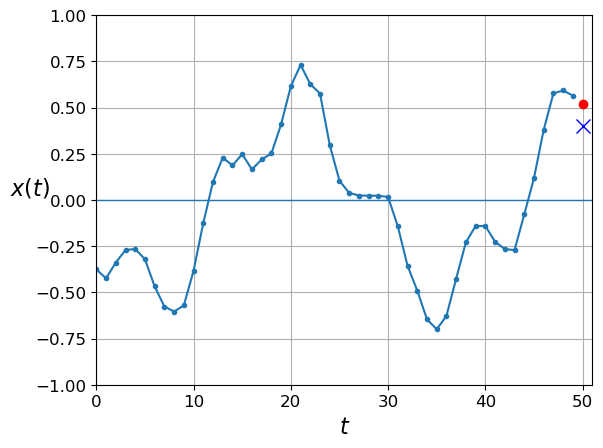

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50, 20)            440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 20)            820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [22]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
55/55 [==============================] - 9s 116ms/step - loss: 0.0160 - val_loss: 0.0039
Epoch 2/20
55/55 [==============================] - 6s 102ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 3/20
55/55 [==============================] - 6s 102ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
55/55 [==============================] - 6s 109ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
55/55 [==============================] - 6s 103ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 6/20
55/55 [==============================] - 6s 108ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
55/55 [==============================] - 5s 99ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/20
55/55 [==============================] - 5s 98ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 9/20
55/55 [==============================] - 6s 108ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/20
55/55 [==============================] - 5s 99ms/step - loss: 0.0031 - val_loss: 0.0031
Ep

In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 14ms/step - loss: 0.0028


0.00284084165468812

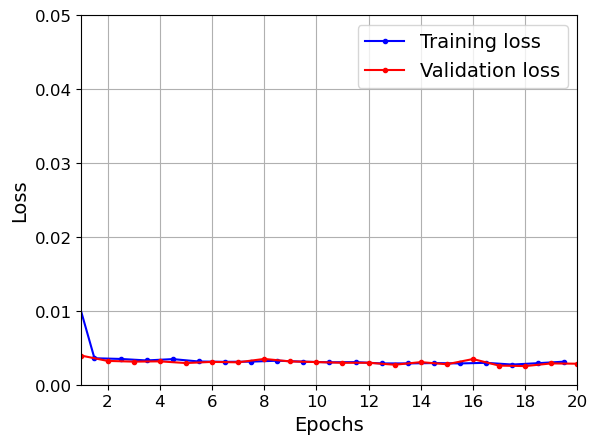

In [24]:
plot_learning_curves(
    history.history["loss"],
    history.history["val_loss"],
)
plt.show()

63/63 [==============================] - 1s 13ms/step


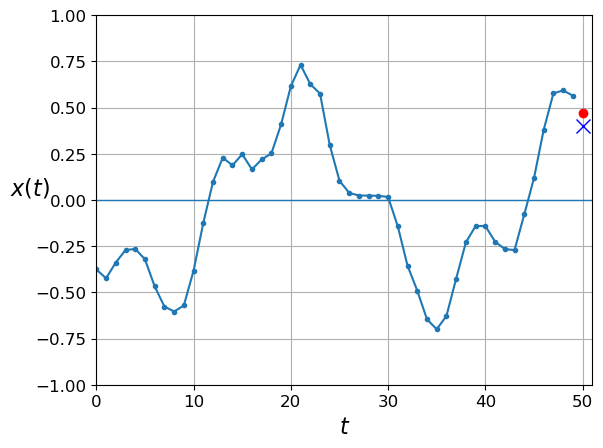

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),
])
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
55/55 [==============================] - 6s 70ms/step - loss: 0.0709 - val_loss: 0.0140
Epoch 2/20
55/55 [==============================] - 4s 64ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 3/20
55/55 [==============================] - 3s 64ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 4/20
55/55 [==============================] - 4s 70ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 5/20
55/55 [==============================] - 4s 75ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 6/20
55/55 [==============================] - 4s 72ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/20
55/55 [==============================] - 4s 64ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 8/20
55/55 [==============================] - 3s 60ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/20
55/55 [==============================] - 4s 66ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/20
55/55 [==============================] - 4s 65ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 11/

In [27]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0025


0.0025079031474888325

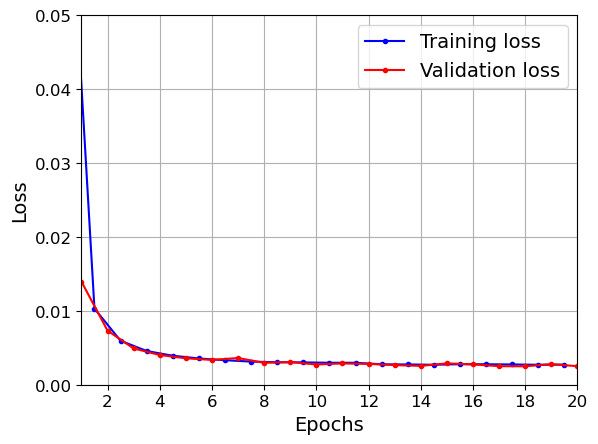

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 9ms/step


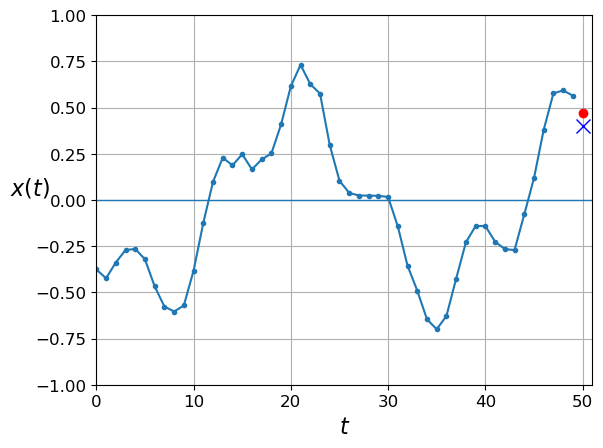

In [29]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [30]:
np.random.seed(43)  # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 24ms/step


In [31]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


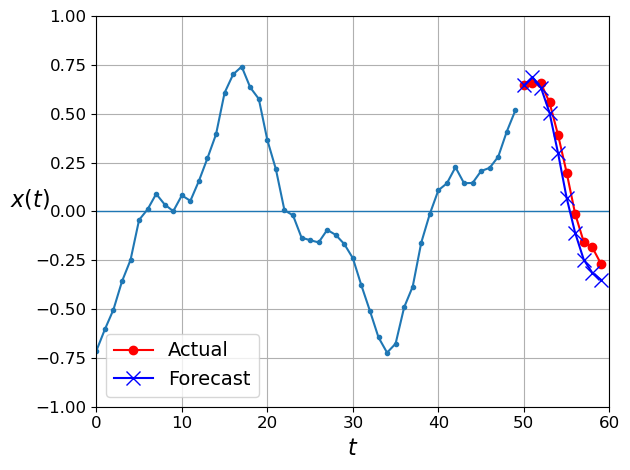

In [32]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(
        np.arange(n_steps, n_steps + ahead),
        Y[0, :, 0],
        "ro-",
        label="Actual",
    )
    plt.plot(
        np.arange(n_steps, n_steps + ahead),
        Y_pred[0, :, 0],
        "bx-",
        label="Forecast",
        markersize=10,
    )
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [34]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 10ms/step


In [35]:
Y_pred.shape

(2000, 10)

In [36]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.020735111

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [37]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=[50, 1]),
     keras.layers.Dense(10)])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/20
55/55 [==============================] - 1s 4ms/step - loss: 0.0802 - val_loss: 0.0357
Epoch 2/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0267
Epoch 3/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0243
Epoch 4/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0230 - val_loss: 0.0224
Epoch 5/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 6/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0206 - val_loss: 0.0204
Epoch 7/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0195
Epoch 8/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 9/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0185
Epoch 10/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 11/20
55/55 [

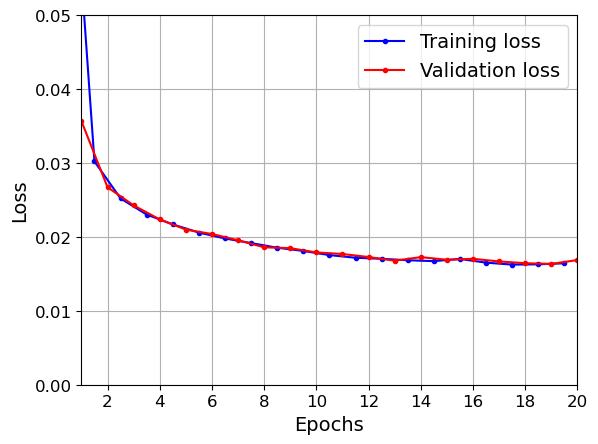

In [39]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
55/55 [==============================] - 6s 67ms/step - loss: 0.2009 - val_loss: 0.0895
Epoch 2/20
55/55 [==============================] - 3s 64ms/step - loss: 0.0654 - val_loss: 0.0490
Epoch 3/20
55/55 [==============================] - 3s 62ms/step - loss: 0.0444 - val_loss: 0.0394
Epoch 4/20
55/55 [==============================] - 3s 63ms/step - loss: 0.0382 - val_loss: 0.0347
Epoch 5/20
55/55 [==============================] - 3s 61ms/step - loss: 0.0338 - val_loss: 0.0311
Epoch 6/20
55/55 [==============================] - 3s 62ms/step - loss: 0.0304 - val_loss: 0.0276
Epoch 7/20
55/55 [==============================] - 4s 64ms/step - loss: 0.0272 - val_loss: 0.0264
Epoch 8/20
55/55 [==============================] - 3s 62ms/step - loss: 0.0246 - val_loss: 0.0225
Epoch 9/20
55/55 [==============================] - 3s 60ms/step - loss: 0.0224 - val_loss: 0.0209
Epoch 10/20
55/55 [==============================] - 3s 61ms/step - loss: 0.0212 - val_loss: 0.0198
Epoch 11/

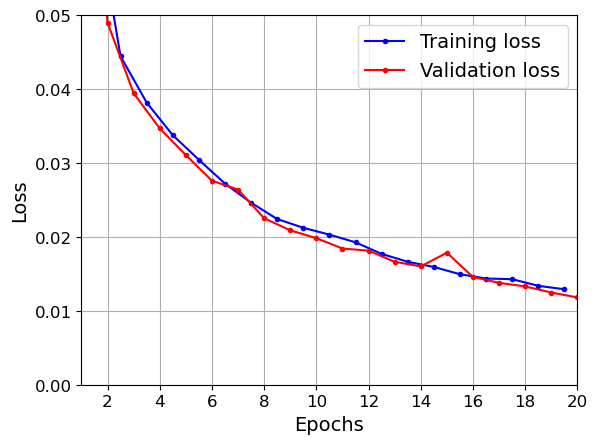

In [41]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [42]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 250ms/step


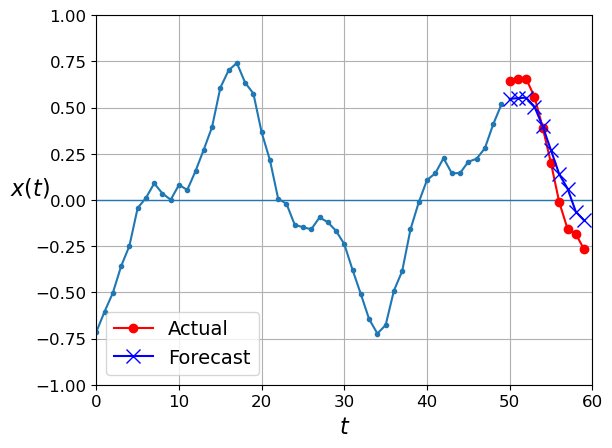

In [43]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [44]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [45]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(loss="mse",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 65ms/step - loss: 0.0498 - last_time_step_mse: 0.0379 - val_loss: 0.0372 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0360 - last_time_step_mse: 0.0233 - val_loss: 0.0326 - val_last_time_step_mse: 0.0202
Epoch 3/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0305 - last_time_step_mse: 0.0180 - val_loss: 0.0289 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0290 - last_time_step_mse: 0.0168 - val_loss: 0.0286 - val_last_time_step_mse: 0.0168
Epoch 5/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0270 - last_time_step_mse: 0.0150 - val_loss: 0.0243 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0242 - last_time_step_mse: 0.0120 - val_loss: 0.0243 - val_last_time_step_mse: 0.0127
Epoch 7/20
219/2

In [47]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


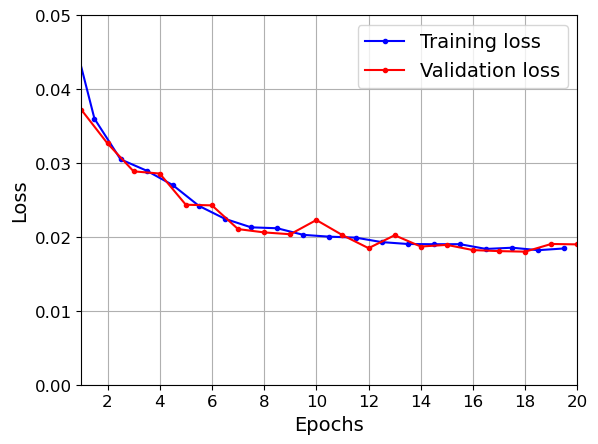

In [48]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [49]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 239ms/step


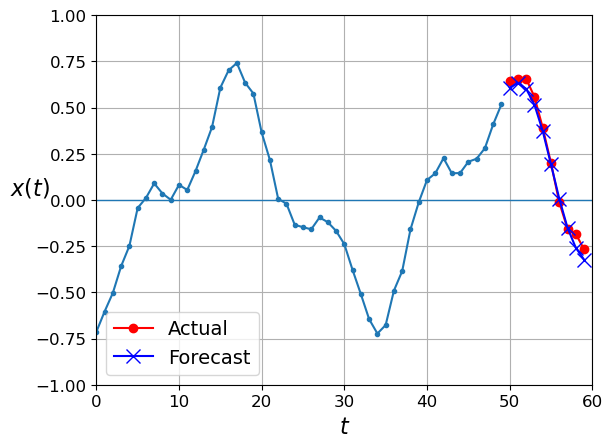

In [50]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTMs

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

2023-05-29 13:12:32.397953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:12:32.399559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:12:32.400953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [52]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          3280      
                                                                 
 time_distributed_1 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2023-05-29 13:12:33.015806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:12:33.017807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:12:33.019248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

218/219 [============================>.] - ETA: 0s - loss: 0.0765 - last_time_step_mse: 0.0615

2023-05-29 13:12:38.483165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:12:38.484799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:12:38.486203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - 6s 14ms/step - loss: 0.0764 - last_time_step_mse: 0.0613 - val_loss: 0.0543 - val_last_time_step_mse: 0.0341
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0479 - last_time_step_mse: 0.0280 - val_loss: 0.0420 - val_last_time_step_mse: 0.0207
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0375 - last_time_step_mse: 0.0167 - val_loss: 0.0348 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0334 - last_time_step_mse: 0.0137 - val_loss: 0.0319 - val_last_time_step_mse: 0.0125
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0313 - last_time_step_mse: 0.0127 - val_loss: 0.0304 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0299 - last_time_step_mse: 0.0121 - val_loss: 0.0292 - val_last_time_step_mse: 0.0121
Epoch 7/20
219/219 [===============

In [54]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0235 - last_time_step_mse: 0.0094


[0.023533688858151436, 0.009369070641696453]

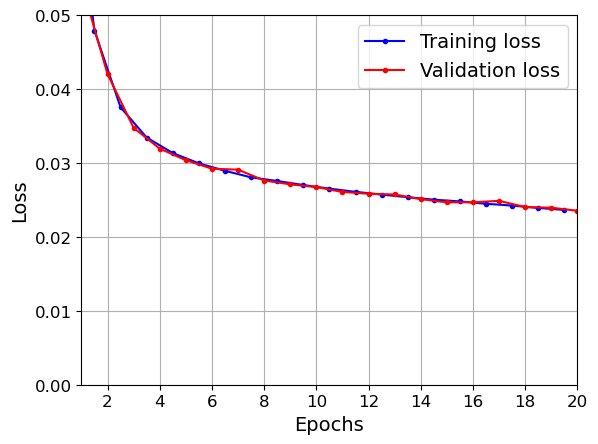

In [55]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [56]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

2023-05-29 13:13:18.802132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:13:18.803585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:13:18.804901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 902ms/step


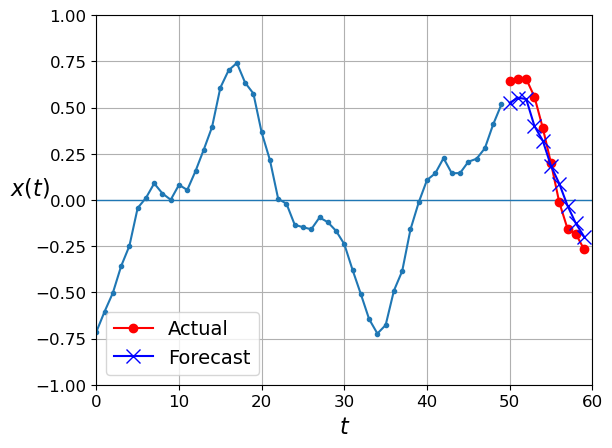

In [57]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

2023-05-29 13:13:19.747064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:13:19.748642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:13:19.749952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [59]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed_2 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2023-05-29 13:13:20.358539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:13:20.360511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:13:20.362115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - ETA: 0s - loss: 0.0732 - last_time_step_mse: 0.0640

2023-05-29 13:13:25.915910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:13:25.917538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:13:25.918955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - 6s 13ms/step - loss: 0.0732 - last_time_step_mse: 0.0640 - val_loss: 0.0524 - val_last_time_step_mse: 0.0413
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0478 - last_time_step_mse: 0.0374 - val_loss: 0.0442 - val_last_time_step_mse: 0.0336
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0420 - last_time_step_mse: 0.0310 - val_loss: 0.0392 - val_last_time_step_mse: 0.0285
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0370 - last_time_step_mse: 0.0254 - val_loss: 0.0345 - val_last_time_step_mse: 0.0230
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0328 - last_time_step_mse: 0.0193 - val_loss: 0.0312 - val_last_time_step_mse: 0.0172
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0302 - last_time_step_mse: 0.0159 - val_loss: 0.0291 - val_last_time_step_mse: 0.0147
Epoch 7/20
219/219 [==============

In [61]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0237 - last_time_step_mse: 0.0101


[0.023727258667349815, 0.010057012550532818]

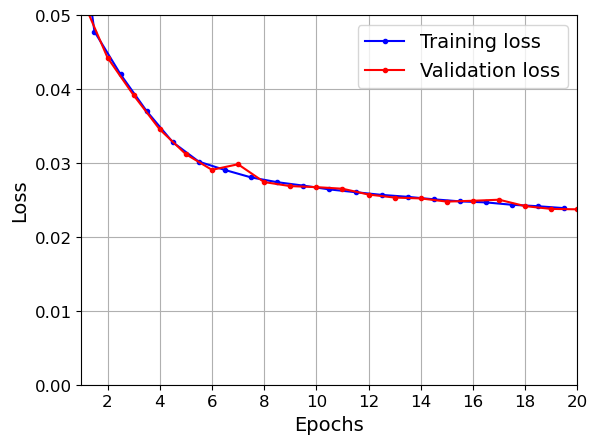

In [62]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [63]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

2023-05-29 13:14:08.339028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:14:08.340796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:14:08.342292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-05-29 13:14:08.540735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:14:08.542614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:14:08.543963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 594ms/step


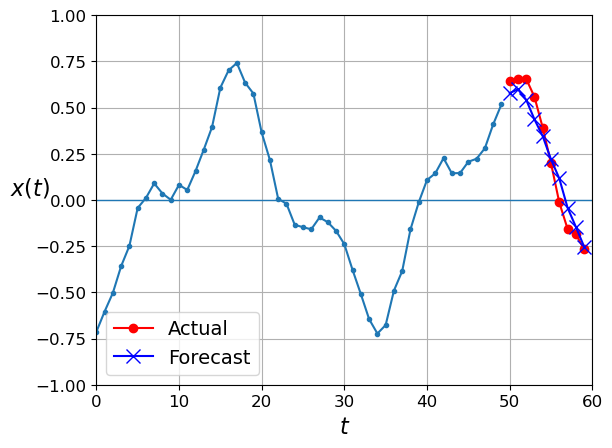

In [64]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [65]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20,
                        kernel_size=4,
                        strides=2,
                        padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train[:, 3::2],
                    epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

2023-05-29 13:14:09.204346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:14:09.206199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:14:09.207690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-05-29 13:14:09.405403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:14:09.407704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:14:09.409053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - ETA: 0s - loss: 0.0708 - last_time_step_mse: 0.0631

2023-05-29 13:14:16.139690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:14:16.141319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:14:16.142939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - 7s 11ms/step - loss: 0.0708 - last_time_step_mse: 0.0631 - val_loss: 0.0461 - val_last_time_step_mse: 0.0380
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0391 - last_time_step_mse: 0.0311 - val_loss: 0.0343 - val_last_time_step_mse: 0.0252
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0309 - last_time_step_mse: 0.0205 - val_loss: 0.0287 - val_last_time_step_mse: 0.0182
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0269 - last_time_step_mse: 0.0154 - val_loss: 0.0257 - val_last_time_step_mse: 0.0144
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0251 - last_time_step_mse: 0.0138 - val_loss: 0.0247 - val_last_time_step_mse: 0.0139
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0240 - last_time_step_mse: 0.0128 - val_loss: 0.0234 - val_last_time_step_mse: 0.0121
Epoch 7/20
219/219 [==================

In [66]:
model.evaluate(X_valid, Y_valid[:, 3::2])

63/63 [==============================] - 0s 3ms/step - loss: 0.0184 - last_time_step_mse: 0.0085


[0.018403824418783188, 0.008459638804197311]

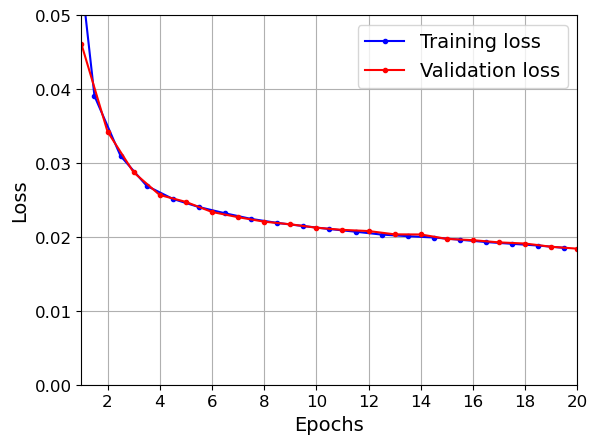

In [67]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [68]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

2023-05-29 13:14:50.279483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:14:50.281062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:14:50.282521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-05-29 13:14:50.742800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 13:14:50.744269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 13:14:50.745638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 880ms/step


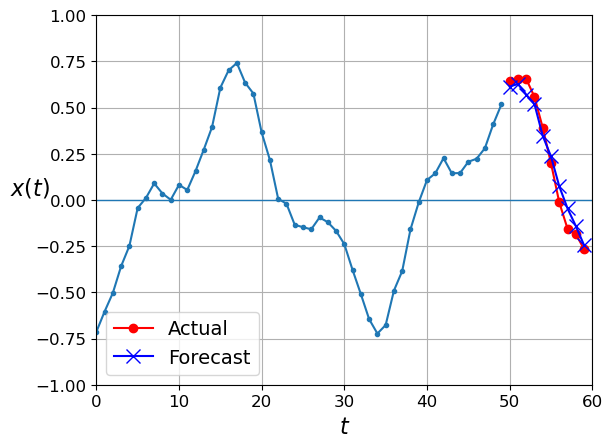

In [69]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()